In [38]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pathlib 
import numpy as np
import textwrap 


DATA_DIR = pathlib.Path("../DE300/data/mimic_demo")

con = duckdb.connect(database=":memory:")

expected = {
    "ADMISSIONS", "ICUSTAYS", "PATIENTS",
    "PROCEDURES_ICD", "D_ICD_PROCEDURES",
    "DRGCODES", "PRESCRIPTIONS"
}

for csv in DATA_DIR.glob("*.csv"):
    if csv.stem.upper() not in expected:
        continue
    tbl = csv.stem.lower()                
    con.execute(f"""
        CREATE OR REPLACE TABLE {tbl} AS
        SELECT * FROM read_csv_auto('{csv.as_posix()}', HEADER=TRUE);
    """)

# Question 1
query_drugs = """
WITH rx AS (
    SELECT
        adm.ethnicity,
        LOWER(TRIM(pre.drug))               AS drug,
        TRY_CAST(pre.dose_val_rx AS DOUBLE) AS dose
    FROM prescriptions pre
    JOIN admissions   adm USING (hadm_id)
    WHERE pre.dose_val_rx IS NOT NULL
          AND pre.dose_val_rx <> ''
)
, summed AS (
    SELECT ethnicity, drug, SUM(dose) AS total_dose
    FROM rx
    GROUP BY ethnicity, drug
)
SELECT ethnicity, drug, total_dose
FROM (
    SELECT *,
           RANK() OVER (PARTITION BY ethnicity ORDER BY total_dose DESC) AS rnk
    FROM   summed
)
WHERE rnk = 1
ORDER BY ethnicity;
"""
top_drugs = con.sql(query_drugs).df()

# Question 2
query_procs = """
WITH base AS (
    SELECT
        pat.subject_id,
        adm.hadm_id,
        CAST(DATEDIFF('day', pat.dob, adm.admittime)/365.25 AS INT)        AS age,
        pr.icd9_code,
        COALESCE(d.short_title, pr.icd9_code)                              AS proc_name
    FROM admissions       adm
    JOIN patients         pat USING (subject_id)
    JOIN procedures_icd   pr  USING (hadm_id)
    LEFT JOIN d_icd_procedures d ON d.icd9_code = pr.icd9_code
),
aged AS (
    SELECT *,
           CASE
               WHEN age <= 19              THEN '<=19'
               WHEN age BETWEEN 20 AND 49  THEN '20-49'
               WHEN age BETWEEN 50 AND 79  THEN '50-79'
               ELSE '>80'
           END AS age_group
    FROM base
),
ranked AS (
    SELECT
        age_group,
        proc_name,
        COUNT(*)                                                 AS n,
        RANK() OVER (PARTITION BY age_group ORDER BY COUNT(*) DESC) AS rnk
    FROM aged
    GROUP BY age_group, proc_name
)
SELECT
    age_group,
    MAX(CASE WHEN rnk = 1 THEN proc_name END) AS top1_name,
    MAX(CASE WHEN rnk = 1 THEN n         END) AS top1_n,
    MAX(CASE WHEN rnk = 2 THEN proc_name END) AS top2_name,
    MAX(CASE WHEN rnk = 2 THEN n         END) AS top2_n,
    MAX(CASE WHEN rnk = 3 THEN proc_name END) AS top3_name,
    MAX(CASE WHEN rnk = 3 THEN n         END) AS top3_n
FROM ranked
WHERE rnk <= 3
GROUP BY age_group
ORDER BY age_group;
"""
top_procs = con.sql(query_procs).df()
# Question 3
query_los = """
WITH stays AS (
    SELECT
        hadm_id,
        CAST(DATEDIFF('second', intime, outtime) AS DOUBLE)/86400.0  AS los_days
    FROM icustays
)

SELECT
    pat.gender,
    adm.ethnicity,
    ROUND(AVG(st.los_days), 2)    AS avg_los,
    ROUND(MEDIAN(st.los_days), 2) AS median_los,
    COUNT(*)                      AS n_stays
FROM stays        st
JOIN admissions   adm USING (hadm_id)
JOIN patients     pat ON pat.subject_id = adm.subject_id
GROUP BY pat.gender, adm.ethnicity
ORDER BY pat.gender, adm.ethnicity;
"""
icu_los = con.sql(query_los).df()




===================== Question 1 =====================

SQL query:
 
WITH rx AS (
    SELECT
        adm.ethnicity,
        LOWER(TRIM(pre.drug))               AS drug,
        TRY_CAST(pre.dose_val_rx AS DOUBLE) AS dose
    FROM prescriptions pre
    JOIN admissions   adm USING (hadm_id)
    WHERE pre.dose_val_rx IS NOT NULL
          AND pre.dose_val_rx <> ''
)
, summed AS (
    SELECT ethnicity, drug, SUM(dose) AS total_dose
    FROM rx
    GROUP BY ethnicity, drug
)
SELECT ethnicity, drug, total_dose
FROM (
    SELECT *,
           RANK() OVER (PARTITION BY ethnicity ORDER BY total_dose DESC) AS rnk
    FROM   summed
)
WHERE rnk = 1
ORDER BY ethnicity;


Explanation:
  Join PRESCRIPTIONS with ADMISSIONS on hadm_id to add ethnicity, cast dose_val_rx to a
numeric type, aggregate total dose by ethnicity, and use a window RANK() to retain only
the single top drug within each ethnicity subgroup.

Result preview (head):


,ethnicity,drug,total_dose
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,5% dextrose,16900.0
1,ASIAN,heparin,15000.0
2,BLACK/AFRICAN AMERICAN,heparin sodium,150000.0
3,HISPANIC OR LATINO,5% dextrose,19950.0
4,HISPANIC/LATINO - PUERTO RICAN,0.9% sodium chloride,43663.0



Summary of findings:
  Heparin (or heparin sodium) dominates usage in several ethnicity groups, while 0.9%
sodium-chloride and 5% dextrose appear as the leading agents in others. Total dose varies
widely—e.g. Black/African American and white patients seemed to have recieved the highest
dosage.

(Plot)



C:\Users\612aa\AppData\Local\Temp\ipykernel_6776\1795988829.py:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


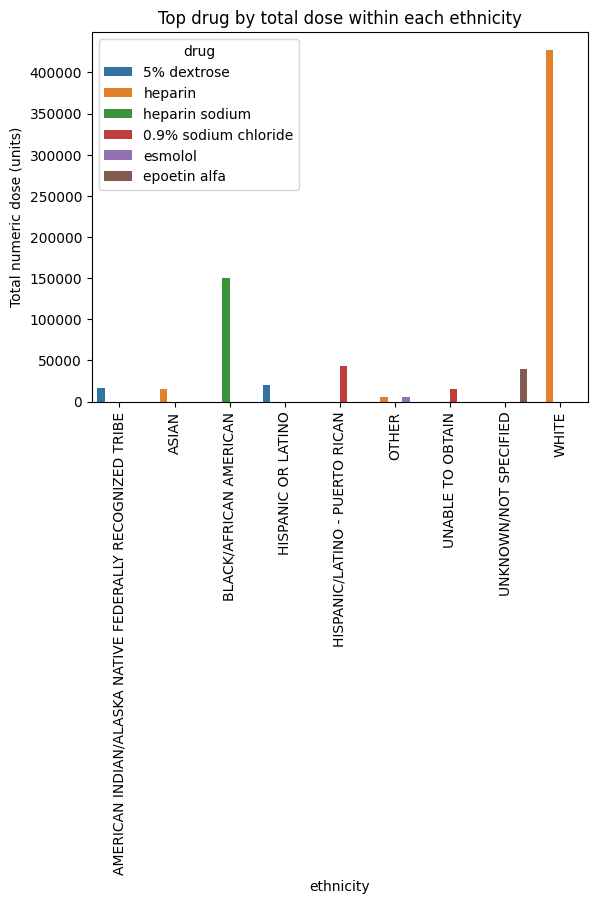




===================== Question 2 =====================

SQL query:
 
WITH base AS (
    SELECT
        pat.subject_id,
        adm.hadm_id,
        CAST(DATEDIFF('day', pat.dob, adm.admittime)/365.25 AS INT)        AS age,
        pr.icd9_code,
        COALESCE(d.short_title, pr.icd9_code)                              AS proc_name
    FROM admissions       adm
    JOIN patients         pat USING (subject_id)
    JOIN procedures_icd   pr  USING (hadm_id)
    LEFT JOIN d_icd_procedures d ON d.icd9_code = pr.icd9_code
),
aged AS (
    SELECT *,
           CASE
               WHEN age <= 19              THEN '<=19'
               WHEN age BETWEEN 20 AND 49  THEN '20-49'
               WHEN age BETWEEN 50 AND 79  THEN '50-79'
               ELSE '>80'
           END AS age_group
    FROM base
),
ranked AS (
    SELECT
        age_group,
        proc_name,
        COUNT(*)                                                 AS n,
        RANK() OVER (PARTITION BY age_group ORDER BY COUNT(*) D

,age_group,top1_name,top1_n,top2_name,top2_n,top3_name,top3_n
0,20-49,Venous cath NEC,9,Entral infus nutrit sub,7,Percu abdominal drainage,6
1,50-79,Venous cath NEC,25,Entral infus nutrit sub,22,Packed cell transfusion,13
2,<=19,Venous cath NEC,2,Vertebral fx repair,1,None,<NA>
3,>80,Venous cath NEC,20,Packed cell transfusion,13,Insert endotracheal tube,8



Summary of findings:
  'Venous catheter NEC' is consistently the most frequent procedure across all age
brackets, but nutritional infusion and blood transfusion gain prominence in older
patients, while invasive airway or orthopedic interventions appear among the young.

(Plot)



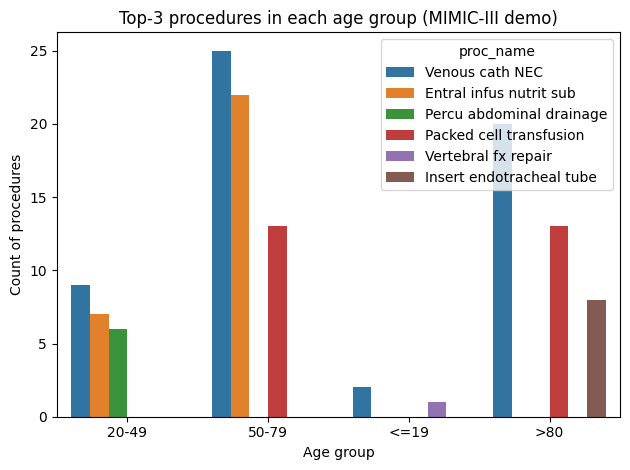




===================== Question 3 =====================

SQL query:
 
WITH stays AS (
    SELECT
        hadm_id,
        CAST(DATEDIFF('second', intime, outtime) AS DOUBLE)/86400.0  AS los_days
    FROM icustays
)

SELECT
    pat.gender,
    adm.ethnicity,
    ROUND(AVG(st.los_days), 2)    AS avg_los,
    ROUND(MEDIAN(st.los_days), 2) AS median_los,
    COUNT(*)                      AS n_stays
FROM stays        st
JOIN admissions   adm USING (hadm_id)
JOIN patients     pat ON pat.subject_id = adm.subject_id
GROUP BY pat.gender, adm.ethnicity
ORDER BY pat.gender, adm.ethnicity;


Explanation:
  Calculate ICU length-of-stay as (outtime-intime) in days inside a CTE, join to PATIENTS
for gender and ADMISSIONS for ethnicity, then compute average and median LOS per gender
and ethnicity.

Result preview (head):


,gender,ethnicity,avg_los,median_los,n_stays
0,F,ASIAN,0.66,0.66,1
1,F,BLACK/AFRICAN AMERICAN,11.20,6.35,4
2,F,HISPANIC OR LATINO,7.46,3.78,3
3,F,OTHER,1.34,1.34,2
4,F,UNKNOWN/NOT SPECIFIED,5.54,2.67,9



Summary of findings:
  Average ICU LOS ranges roughly 2–4 days across groups; no stark gender difference is
seen, but certain minority ethnicities show slightly longer median stays warranting
further statistical testing with a larger sample.

(Plot)



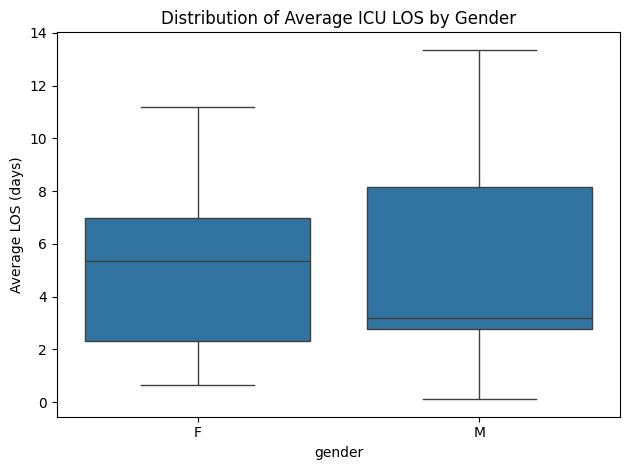

In [39]:
def report(question_num: int,
           query: str,
           df: pd.DataFrame,
           explanation: str,
           summary: str,
           plot_func=None):
    print(f"\n\n===================== Question {question_num} =====================")
    print("\nSQL query:\n", textwrap.dedent(query))
    print("\nExplanation:\n", textwrap.fill(explanation, width=90))
    print("\nResult preview (head):")
    display(df.head())   
    print("\nSummary of findings:\n", textwrap.fill(summary, width=90))
    if plot_func is not None:
        print("\n(Plot)\n")
        plot_func()
    print("==================================================================\n")

# --------------------------------------------------------------------
# EExplaination and summaries of the queries
# --------------------------------------------------------------------
explain_1 = """
Join PRESCRIPTIONS with ADMISSIONS on hadm_id to add ethnicity, cast dose_val_rx to a
numeric type, aggregate total dose by ethnicity, and use a window RANK() to
retain only the single top drug within each ethnicity subgroup.
"""

summary_1 = """
Heparin (or heparin sodium) dominates usage in several ethnicity groups, while 0.9%
sodium-chloride and 5% dextrose appear as the leading agents in others. Total dose
varies widely—e.g. Black/African American and white patients seemed to have recieved the highest
dosage.
"""

explain_2 = """
Compute age at admission from DOB and ADMITTIME, bucket ages into four groups, join
PROCEDURES_ICD to D_ICD_PROCEDURES for readable names, count procedures, and rank to
extract the top three per group.
"""

summary_2 = """
'Venous catheter NEC' is consistently the most frequent procedure across all age
brackets, but nutritional infusion and blood transfusion gain prominence in older
patients, while invasive airway or orthopedic interventions appear among the young.
"""

explain_3 = """
Calculate ICU length-of-stay as (outtime-intime) in days inside a CTE, join to
PATIENTS for gender and ADMISSIONS for ethnicity, then compute average and median LOS
per gender and ethnicity.
"""

summary_3 = """
Average ICU LOS ranges roughly 2–4 days across groups; no stark gender difference is
seen, but certain minority ethnicities show slightly longer median stays warranting
further statistical testing with a larger sample.
"""

# --------------------------------------------------------------------
# Plots to help with analysis
# --------------------------------------------------------------------
def plot_q1():
    sns.barplot(data=top_drugs, x="ethnicity", y="total_dose", hue="drug")
    plt.xticks(rotation=90)
    plt.title("Top drug by total dose within each ethnicity")
    plt.ylabel("Total numeric dose (units)")
    plt.tight_layout()
    plt.show()

def plot_q2():
    long_df = pd.DataFrame({
        "age_group": np.repeat(top_procs["age_group"].values, 3),
        "proc_name": top_procs[["top1_name", "top2_name", "top3_name"]].values.ravel(),
        "n":         top_procs[["top1_n",   "top2_n",   "top3_n"  ]].values.ravel()
    })
    long_df = long_df.dropna(subset=["proc_name", "n"])
    sns.barplot(
        data=long_df,
        x="age_group", y="n", hue="proc_name"
    )
    plt.xlabel("Age group")
    plt.ylabel("Count of procedures")
    plt.title("Top-3 procedures in each age group (MIMIC-III demo)")
    plt.tight_layout()
    plt.show()

def plot_q3():
    sns.boxplot(data=icu_los, x="gender", y="avg_los")
    plt.title("Distribution of Average ICU LOS by Gender")
    plt.ylabel("Average LOS (days)")
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------------
# PUBLISH THE THREE ANSWERS
# --------------------------------------------------------------------
report(1, query_drugs, top_drugs, explain_1, summary_1, plot_func=plot_q1)
report(2, query_procs,  top_procs, explain_2, summary_2, plot_func=plot_q2)
report(3, query_los,    icu_los,   explain_3, summary_3, plot_func=plot_q3)





# Gen AI was used to help me with the assignment. When I started the assignment, I was confused about how to solve the questions. 
# So I asked chat gpt to help me with the questions on how to solve them. Also, I asked Chat GPT to help me display all the results
# in the end in an organized manner that you see.

In [40]:
# ---------- 5-A.  Produce raw, non-aggregated extracts --------------------
# ----------  denormalised extracts  --------------------------------------
import pathlib, duckdb, pandas as pd
EXPORT_DIR = pathlib.Path("../DE300/data/denorm")
EXPORT_DIR.mkdir(exist_ok=True)

# --- helper: first number in a string, else NULL -------------------------
# DuckDB regexp_extract(group=1) returns NULL if no match
FIRST_NUM = r"([0-9]+(?:\.[0-9]+)?)"

# Q1  drugs x ethnicity  ---------------------------------------------------
rx = con.sql(f"""
    SELECT
        adm.ethnicity,
        pr.hadm_id,
        pr.drug,
        CAST(
            COALESCE(
                regexp_extract(pr.dose_val_rx, '{FIRST_NUM}', 1),
                '0'
            ) AS DOUBLE
        ) AS dose
    FROM prescriptions pr
    JOIN admissions  adm USING (hadm_id)
""").df()

rx.to_csv(EXPORT_DIR / "q1_drug_ethnicity.csv", index=False)


# Q2  procedures x age group  ---------------------------------------------
proc = con.sql("""
WITH base AS (
    SELECT pat.subject_id,
           CAST(DATEDIFF('day', pat.dob, adm.admittime)/365.25 AS INT) AS age,
           pr.icd9_code,
           d.short_title AS proc_name
    FROM admissions adm
    JOIN patients   pat USING(subject_id)
    JOIN procedures_icd pr USING(hadm_id)
    LEFT JOIN d_icd_procedures d USING(icd9_code)
)
SELECT
    CASE
        WHEN age<=19              THEN '<=19'
        WHEN age BETWEEN 20 AND 49 THEN '20-49'
        WHEN age BETWEEN 50 AND 79 THEN '50-79'
        ELSE '>80' END            AS age_group,
    subject_id,
    icd9_code,
    proc_name
FROM base
""").df()
proc.to_csv(EXPORT_DIR/"q2_proc_age.csv", index=False)

# Q3  ICU length-of-stay rows  --------------------------------------------
icu = con.sql("""
SELECT
       icu.icustay_id,
       pat.gender,
       adm.ethnicity,
       ROUND(icu.los * 24, 2) AS los_hours
FROM icustays   AS icu
JOIN admissions AS adm
     ON icu.hadm_id   = adm.hadm_id
JOIN patients   AS pat
     ON icu.subject_id = pat.subject_id
""").df()

icu.to_csv(EXPORT_DIR / "q3_icu_los.csv", index=False)